In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

Load the picture of Politecnico’s facade polimi compressed.jpg. Please notice that the RGB object is list of three matrices, each one corresponding to a different "channel" (i.e. red, greed, or blue).

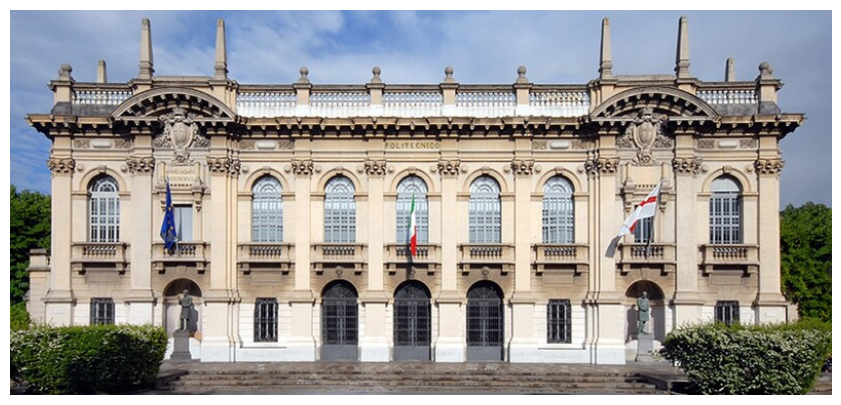

In [4]:
image_path = 'data/polimi_compress.jpg'
img = imread(image_path)
img_RGB = [np.array(img[:,:,i], dtype = np.float64)/255 for i in range(3)]
def plot_image(RGB, ax = None):
  if ax is None:
    _, ax = plt.subplots(1,1, figsize = (12,5))
  ax.imshow(np.clip(np.stack(RGB, axis = 2),0,1))
  plt.axis('off')

plot_image(img_RGB)

Now, randomly replace 70% of the pixels with random colors.

In [5]:
damage_fraction = 0.7

np.random.seed(0)
mask_remove = np.random.choice(a=[True, False], size=(img.shape[0],img.shape[1]), \
p=[damage_fraction, 1-damage_fraction])
mask_keep = np.logical_not(mask_remove)

img_damaged_RGB = [img_RGB[i].copy() for i in range(3)]
for i in range(3):
  img_damaged_RGB[i][mask_remove] = np.random.rand(np.sum(mask_remove))

Display the damaged image.

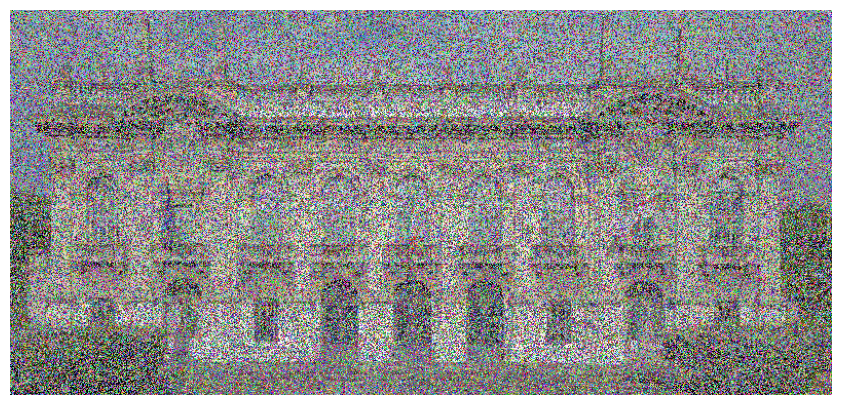

In [6]:
plot_image(img_damaged_RGB)

Implement the singular value truncation (SVT) algorithm to reconstruct the picture from img (Hint: apply the algorithm independently to each channel.)

In [7]:
n_max_iter = 100
threshold = 100.0
increment_tol = 1e-6

img_recon_RGB = []

for j in range(3):
    A = img_damaged_RGB[j].copy()
    for i in range(n_max_iter):
        A_old = A.copy()
        U, s, VT = np.linalg.svd(A, full_matrices=False)  # SVD

        s[s < threshold] = (
            0  # Threshold on singular values (truncation): put the lower to 0
        )
        A = U @ np.diag(s) @ VT  # Reconstruct the matrix

        A[mask_keep] = img_damaged_RGB[j][
            mask_keep
        ]  # Put the known values to the reconstructed matrix
        increment = np.linalg.norm(A - A_old)  # Compute the increment

        if increment < increment_tol:
            break

    img_recon_RGB.append(A)

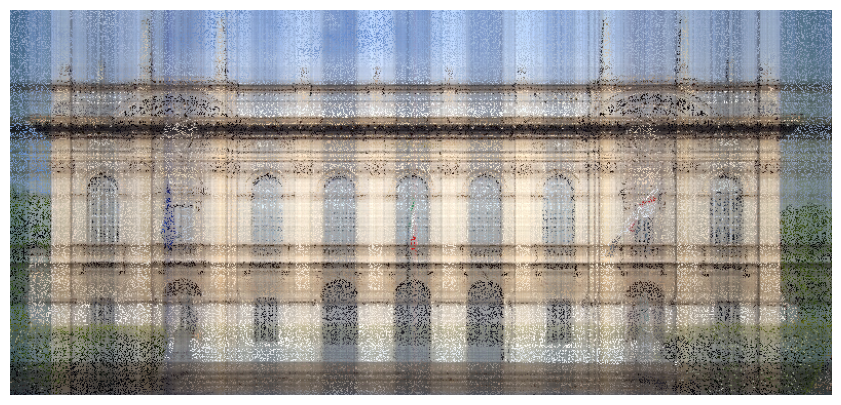

In [8]:
plot_image(img_recon_RGB)

Try to optimize by trial and error the threshold on the singular values. Run the algorithm for 20 iterations and plot the resulting image against the original and the damaged one.

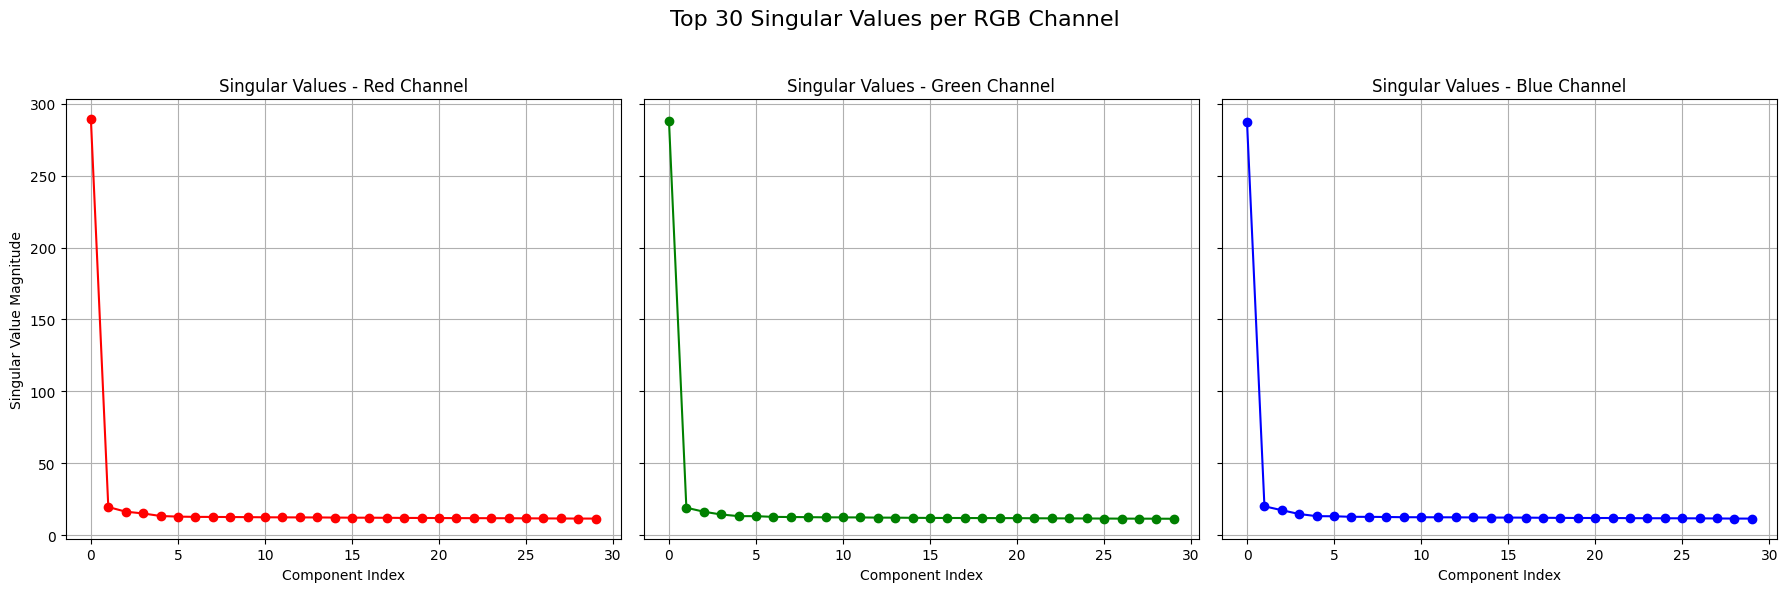

In [ ]:
# Compute singular values for each RGB channel
rgb_s = [np.linalg.svd(img_damaged_RGB[i], full_matrices=False)[1] for i in range(3)]

# Set up colors and titles
colors = ['r', 'g', 'b']
titles = ['Singular Values - Red Channel', 'Singular Values - Green Channel', 'Singular Values - Blue Channel']

# Plot the first 30 singular values for each channel
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i in range(3):
    axs[i].plot(rgb_s[i][:30], 'o-', color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Component Index')
    axs[i].grid(True)

axs[0].set_ylabel('Singular Value Magnitude')
fig.suptitle('Top 30 Singular Values per RGB Channel', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

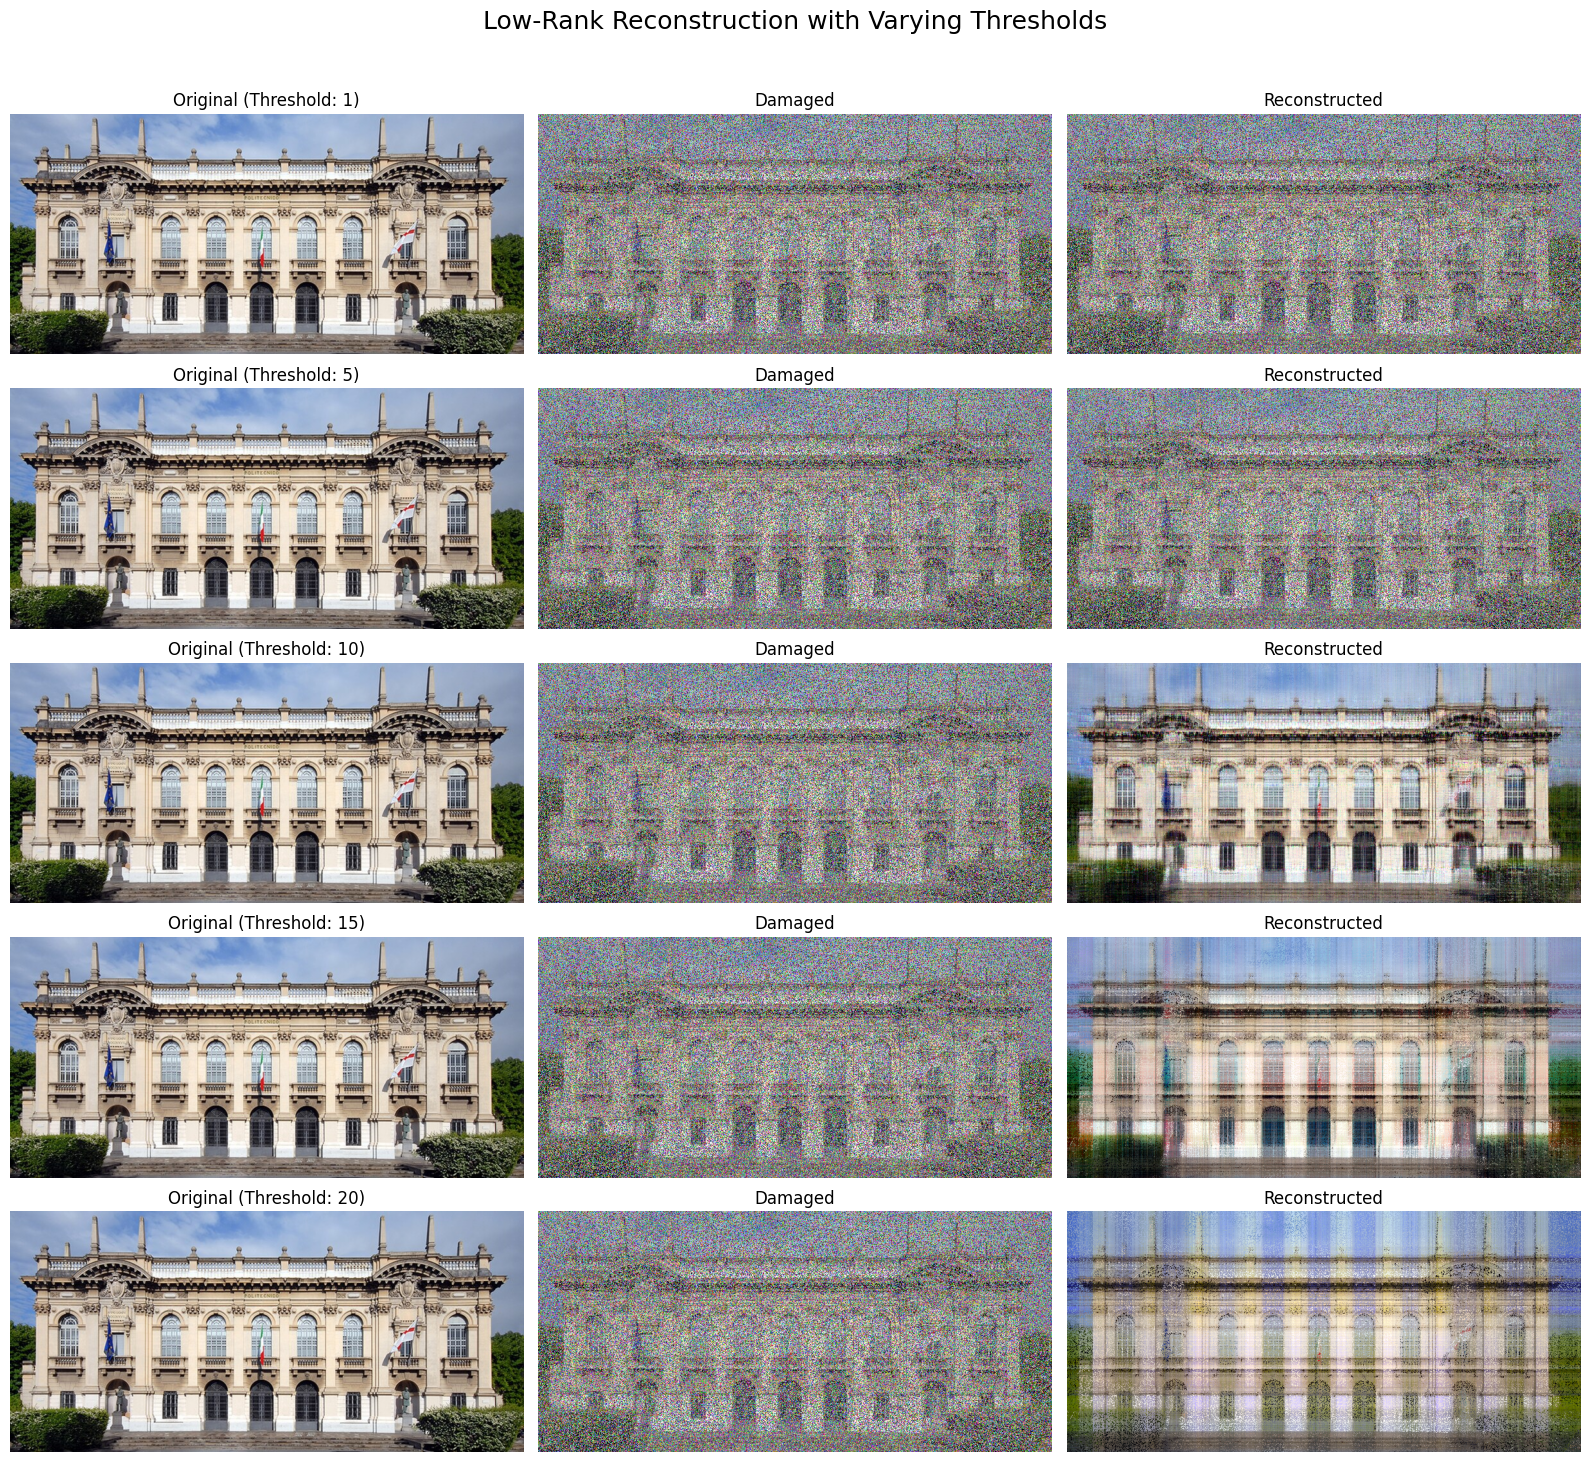

In [11]:
threshold_list = [1, 5, 10, 15, 20]
n_max_iter = 20
increment_tol = 1e-6

images = []

# Perform low-rank matrix completion for each threshold
for t in threshold_list:
    img_recon_RGB = []
    for j in range(3):  # For R, G, B channels
        A = img_damaged_RGB[j].copy()
        for _ in range(n_max_iter):
            A_old = A.copy()
            U, s, VT = np.linalg.svd(A, full_matrices=False)

            s[s < t] = 0  # Apply threshold
            A = U @ np.diag(s) @ VT
            A[mask_keep] = img_damaged_RGB[j][mask_keep]  # Restore known pixels

            if np.linalg.norm(A - A_old) < increment_tol:
                break

        img_recon_RGB.append(A)
    images.append(img_recon_RGB)

# Plotting
n_images = len(images)
fig, axs = plt.subplots(nrows=n_images, ncols=3, figsize=(16, 3 * n_images))

for i in range(n_images):
    axs[i, 0].imshow(np.clip(np.moveaxis(img_RGB, 0, -1), 0, 1))
    axs[i, 0].set_title(f"Original (Threshold: {threshold_list[i]})")

    axs[i, 1].imshow(np.clip(np.moveaxis(img_damaged_RGB, 0, -1), 0, 1))
    axs[i, 1].set_title("Damaged")

    axs[i, 2].imshow(np.clip(np.moveaxis(images[i], 0, -1), 0, 1))
    axs[i, 2].set_title("Reconstructed")

    for j in range(3):
        axs[i, j].axis('off')

fig.suptitle("Low-Rank Reconstruction with Varying Thresholds", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Comment on the impact of the threshold on the results.

If we keep a low threshold such as k=1, or k=5 we are not reconstructing well the original matrix because we are keeping a too small number of singular values and we are reducing too much the rank of the original matrix, loosing a lot of information about it.

Instead by considering a high threshold such as k=20, we are not reconsrtucting well the original matrix because we are keeping a too high number of singular values which can hold also the external noise and then by performing SVT we are not able get rid of it.

# Exercise 2

In [51]:
import numpy as np
import matplotlib.pyplot as plt

Explain how a perceptron works and how to apply the gradient descent method to optimize the parameters of the perceptron.


A **perceptron** is the simplest form of a neural network and is a type of artificial neuron. It takes multiple binary inputs and produces a single binary output. The perceptron works by combining the input values with weights, applying an activation function, and producing an output.

- **Inputs**: Each input is multiplied by a weight. These weights represent the strength of the respective input. Mathematically, for an input x and a weight w, the weighted input is x * w.

- **Summation**: The weighted inputs are summed up. This is a linear combination of the inputs and weights, often represented as the dot product of the input vector and weight vector, plus a bias term (b):
$$ ∑_i(x_i \cdot w_i) + b_i $$

- **Activation Function**: The summation is passed through an activation function. The purpose of the activation function is to introduce non-linearity to the model. Common choices include the step function, sigmoid function, or the rectified linear unit (ReLU). The output of the activation function is the final output of the perceptron.

- **Output**: The output of the activation function is the output of the perceptron. For binary classification, it might be 0 or 1 depending on whether the threshold is crossed.

The perceptron's parameters are the weights (w) and the bias (b). Training a perceptron involves adjusting these parameters to correctly classify input data. The gradient descent method is commonly used for this purpose.

**Gradient Descent**:

Gradient descent is an optimization algorithm that minimizes a cost function by iteratively moving towards the minimum of the function. In the context of a perceptron, the cost function measures the difference between the predicted output and the actual output.

The steps of the gradient descent algorithm for a perceptron are as follows:

1. **Initialize Weights and Bias**: Start with random values for the weights and the bias.

2. **Forward Pass**: Compute the predicted output using the current weights and bias.

3. **Calculate the Cost**: Compute the cost or error, which measures how far off the predicted output is from the actual output.

4. **Backward Pass (Backpropagation)**: Compute the gradients of the cost with respect to the weights and bias. This involves applying the chain rule of calculus to calculate how much each weight and bias contributed to the error.

5. **Update Weights and Bias**: Adjust the weights and bias in the opposite direction of the gradient. This is done to minimize the cost function. The update rule is typically of the form: $ new\_weight = old\_weight − \alpha\times gradient $
where $\alpha$ is the learning rate, a hyperparameter controlling the size of the update.

6. **Repeat**: Repeat steps 2-5 until the cost converges to a minimum or reaches an acceptable level.

The **learning rate ($\alpha$)** is an important parameter in gradient descent. It determines the size of the steps taken during each iteration. Too large a learning rate might cause the algorithm to overshoot the minimum, while too small a learning rate may result in slow convergence.

Consider the following set of data

$$  x_1 = (2, −1),y_1 = 1, \\
x_2 = (−1, 1),y_2 = 0, \\
x_3 = (2, 0.5),y_3 = 1, \\
x_4 = (0.2, −0.2),y_4 = 0, \\
x_5 = (0.5, −1),y_5 = 1, \\
x_6 = (2, 1),y_6 = 0. $$



Design matrix X (with bias):
[[ 1.   2.  -1. ]
 [ 1.  -1.   1. ]
 [ 1.   2.   0.5]
 [ 1.   0.2 -0.2]
 [ 1.   0.5 -1. ]
 [ 1.   2.   1. ]]


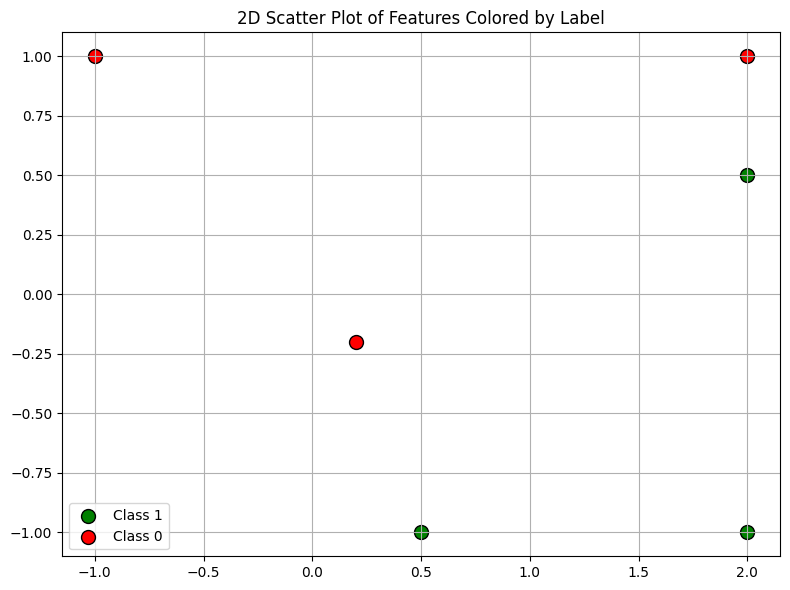

In [52]:
# Define dataset
data = np.array([
    [2, -1, 1],
    [-1, 1, 0],
    [2, 0.5, 1],
    [0.2, -0.2, 0],
    [0.5, -1, 1],
    [2, 1, 0]
])

# Split into features and target
Y = data[:, -1]                     # Labels (0 or 1)
X_raw = data[:, :-1]               # Feature matrix
X = np.column_stack([np.ones(X_raw.shape[0]), X_raw])  # Add bias term

# Print design matrix
print("Design matrix X (with bias):")
print(X)

# 2D Scatter plot colored by label
plt.figure(figsize=(8, 6))
colors = ['red' if y == 0 else 'green' for y in Y]
labels = ['Class 0' if y == 0 else 'Class 1' for y in Y]

for i in range(len(X_raw)):
    plt.scatter(X_raw[i, 0], X_raw[i, 1], color=colors[i], s=100, edgecolor='black', label=labels[i])

# Avoid duplicate legend entries
handles, unique_labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(unique_labels, handles))
plt.legend(unique.values(), unique.keys())

# Axis labels and title
plt.title('2D Scatter Plot of Features Colored by Label')
plt.grid(True)
plt.tight_layout()
plt.show()

Construct a possible separating hyperplane by hand. Express the parameters of the hyperplane in terms of the three parameters of the perceptron

We can for example consider the points:
$$ x_1 = (2,\frac{3}{4}) \quad and \\
x_2 = (0, - \frac{1}{2})$$
to build a line:
$$ m = \frac{5}{8} \quad and \quad q = -\frac{1}{2} \\
x_2 = mx_1 + q \\
-mx_1 + x_2 + q = 0 $$
And finally as the parameters of the perceptron:
$W = [-\frac{5}{8}]^T, b = -\frac{1}{2}  $

In [53]:
# Define decision boundary: y = mx + q
m_hand = 5 / 8
q_hand = -1 / 2

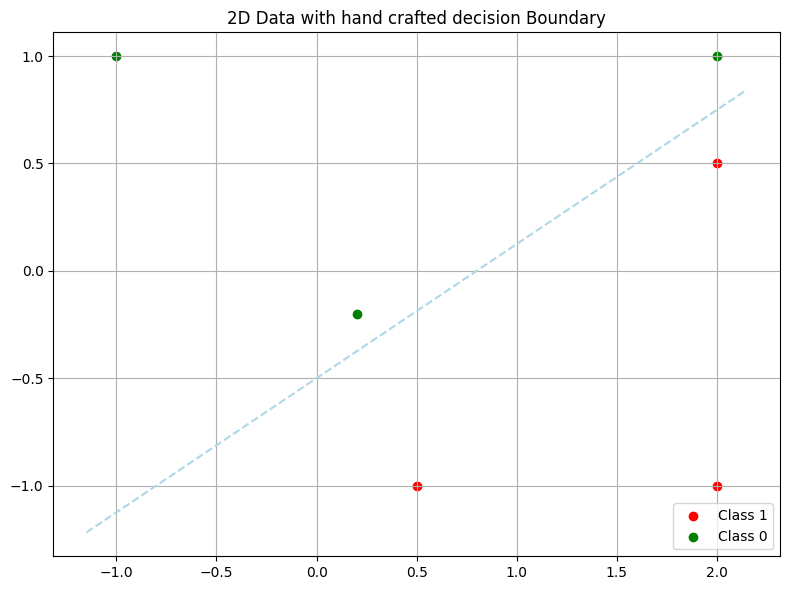

In [54]:
# Plot data points
plt.figure(figsize=(8, 6))
plt.scatter(X[Y == 1, 1], X[Y == 1, 2], color='r', label='Class 1')
plt.scatter(X[Y == 0, 1], X[Y == 0, 2], color='g', label='Class 0')

# Plot decision boundary line
x_min, x_max = plt.xlim()
xx = np.linspace(x_min, x_max, 100)
yy = m_hand * xx + q_hand
plt.plot(xx, yy, color='lightblue', linestyle='--')

# Labels and legend
plt.title('2D Data with hand crafted decision Boundary')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Implement and apply the perceptron algorithm using $w_0 = (1,0)$ and $b_0 = 0$. Consider a learning rate $η =2$. 

Draw on a figure the obtained hyperplane along with the data.

In [55]:
def step_activation(z):
    return 1 if z >= 0 else 0

In [56]:
n_iter = 50
params = np.array([0.0, 1.0, 0.0])  # [bias, w1, w2]
learning_rate = 2

# Perceptron learning loop
for iteration in range(n_iter):
    i = iteration % X.shape[0]  # cycle through samples
    z = X[i] @ params
    Y_hat = step_activation(z)
    error = Y[i] - Y_hat
    params += learning_rate * error * X[i]  # update rule

# Extract decision boundary from params: w1*x + w2*y + b = 0 → y = -(w1/w2)x - b/w2
w1, w2 = params[1], params[2]
b = params[0]
m = -w1 / w2
q = -b / w2

# Print final parameters and boundary
print("Final Parameters:", params)
print(f"Decision boundary: y = {m:.2f}x + {q:.2f}")

Final Parameters: [-4.   4.4 -5.4]
Decision boundary: y = 0.81x + -0.74


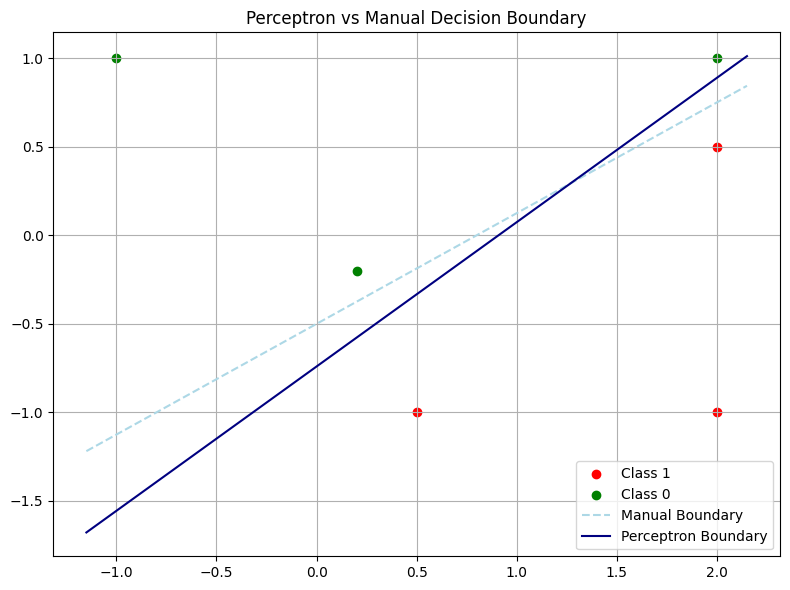

In [57]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[Y == 1, 1], X[Y == 1, 2], color='r', label='Class 1')
plt.scatter(X[Y == 0, 1], X[Y == 0, 2], color='g', label='Class 0')

# x range and linspace
x_min, x_max = plt.xlim()
xx = np.linspace(x_min, x_max, 100)

# Hand-defined decision boundary
yy_hand = m_hand * xx + q_hand
plt.plot(xx, yy_hand, color='lightblue', linestyle='--', label='Manual Boundary')

# Perceptron decision boundary
yy_perceptron = m * xx + q
plt.plot(xx, yy_perceptron, color='navy', linestyle='-', label='Perceptron Boundary')



# Labels and formatting
plt.title('Perceptron vs Manual Decision Boundary')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()